In [1]:
import logging
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model_name="gpt-4o-mini",temperature=0)

In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("user",
         """자기소개서 문항: {question}
         위 문항에 대해 답변을 작성해 주세요.
         답변은 최대 {max_length}자 이내이며, 최소 {lower_bound}자 이상 작성되어야 합니다.
         {additional_instruction}
         답변은 해당 조건을 엄격하게 준수해야 합니다.
         """),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [2]:
from typing import Sequence, Tuple
import math
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    index: int
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: str
    max_length: int
    lower_bound: int
    additional_instruction: str
    answer_length: int
    prev_missing: int
    prev_excess: int

workflow = StateGraph(state_schema=State)

def init_state(state: State):
    lower_bound = math.ceil(state["max_length"] * 0.995)

    return {"index": 0,"additional_instruction": "", "answer_length": 0,"lower_bound": lower_bound, "prev_missing": None, "prev_excess": None}

def check_answer_length(state: State):
    if state["index"] == 0:
        return "make_additional_instruction"
    else:
        if state["answer_length"] < state["lower_bound"] or state["answer_length"] > state["max_length"]:
            return "make_additional_instruction"
        else:
            return END

def make_additional_instruction(state: State):
    answer_length = state["answer_length"]
    lower_bound = state["lower_bound"]
    max_length = state["max_length"]
    prev_missing = state["prev_missing"]
    prev_excess = state["prev_excess"]
    index = state["index"] + 1
    if state["index"] != 0:
        if answer_length < lower_bound:
            missing_min = lower_bound - answer_length
            missing_max = max_length - answer_length
            if prev_missing is not None:
                additional_instruction = (
                    f"이전에 부족했던 추가 문자 수는 {prev_missing}자였으나, "
                    f"실제로 추가된 문자는 {prev_missing - missing_min}자였습니다. "
                    f"그 차이는 {abs(missing_min)}자입니다.\n"
                    f"현재 생성된 답변이 {answer_length}자입니다. "
                    f"최소 추가로 {missing_min}자에서 최대 {missing_max}자를 더 작성하여 전체 조건(총 {lower_bound}~{max_length}자)을 만족하도록 보완해 주세요.\n"
                )
            else:
                additional_instruction = (
                    f"현재 생성된 답변이 {answer_length}자입니다. "
                    f"최소 추가로 {missing_min}자에서 최대 {missing_max}자를 더 작성하여 전체 조건(총 {lower_bound}~{max_length}자)을 만족하도록 보완해 주세요.\n"
                )
            prev_missing = missing_min
            return {"additional_instruction": additional_instruction, "prev_missing": prev_missing, "index": index}
        else: # answer_length > max_length 인 경우
            excess = answer_length - max_length
            if prev_excess is not None:
                additional_instruction = (
                    f"이전에 초과된 문자 수는 {prev_excess}자였으나, "
                    f"실제로 제거된 문자는 {prev_excess - excess}자였습니다. "
                    f"그 차이는 {abs(excess)}자입니다.\n"
                    f"현재 생성된 답변이 {answer_length}자입니다. "
                    f"초과된 {excess}자를 제거하여 전체 조건(총 {lower_bound}~{max_length}자)을 만족하도록 보완해 주세요.\n"
                )
            else:
                additional_instruction = (
                    f"현재 생성된 답변이 {answer_length}자입니다. "
                    f"초과된 {excess}자를 제거하여 전체 조건(총 {lower_bound}~{max_length}자)을 만족하도록 보완해 주세요.\n"
                )
            prev_excess = excess
            return {"additional_instruction": additional_instruction, "prev_excess": prev_excess, "index": index}
    else:
        return {"additional_instruction": "", "index": index}


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

def checkpoint(state: State):
    logger.debug("="*100 + f"checkpoint: {state}" + "="*100)
    if state["index"] == 0:
        return {"answer_length": 0}
    else:
        answer_length= len(state["messages"][-1].content)
        return {"answer_length": answer_length}

workflow.add_edge(START, "init_state")
workflow.add_edge("init_state","checkpoint")
workflow.add_conditional_edges(
    source="checkpoint",
    path=check_answer_length,
    path_map={"make_additional_instruction": "make_additional_instruction", END: END}
)
workflow.add_edge("make_additional_instruction", "model")
workflow.add_edge("model", "checkpoint")

workflow.add_node("init_state", init_state)
workflow.add_node("checkpoint", checkpoint)
workflow.add_node("make_additional_instruction", make_additional_instruction)
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

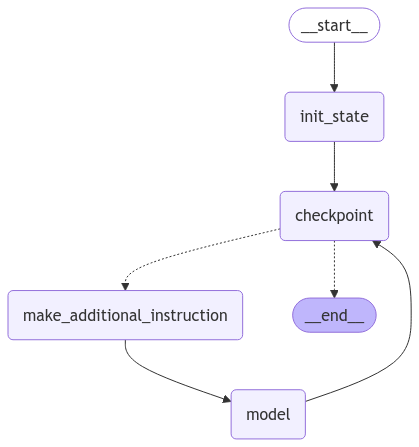

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [5]:
config = {"configurable": {"thread_id": "456"}}

In [6]:
input = {"question": "당신의 장점은 무엇입니까?", "max_length": 1000}
output = app.invoke(input, config)
output["messages"][-1].pretty_print()

IndexError: list index out of range

In [17]:
query = "Hi! I'm Jaehyun"

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hi Jaehyun! How can I assist you today?


In [18]:
query = "What is my name?"

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Jaehyun. How can I help you today?


In [19]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information about users unless you've shared it with me in this conversation. If you'd like, you can tell me your name!


In [20]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Jaehyun. If you have any other questions or need assistance, feel free to ask!


In [22]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 조선시대 사람입니다. 조선시대 사람 말투를 사용해서 대답해주세요."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [23]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

workflow.compile()

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [24]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jaehyun"

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

아, 자현님이시구려! 뵙게 되어 반갑사옵니다. 무슨 일이신지요?


In [25]:
query = "내 이름이 뭐지?"

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

자현님이라 하셨사오니, 그 이름이 니가 내 이름이라 생각하옵니다. 혹시 궁금한 일이 있으신가요?


In [26]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [27]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

workflow = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [28]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Jaehyun"
language = "Korean"

input_messages = [HumanMessage(content=query)]
output = app.invoke({"messages":input_messages, "language": language}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 재현님! 어떻게 도와드릴까요?


In [29]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 재현입니다.


In [30]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]